**CLASSIFICADOR DE ENQUADRAMENTO DE CARGOS DE PROFISSIONAIS**

**Contexto**: Temos um conjunto de registros de enquadramentos de recursos humanos que representam diversos cargos na empresa. Cada cargo é representando por um código de material diferente. Cada material representa um valor em uma condição de preço, que será base para criação de um faturamento ao cliente. O objetivo deste notebook é criar um modelo de visão computacional que consiga classificar uma novo registro de enquadramento em alguma categoria de material existente.

**Estrutura**: O notebook está dividido assim:

1.   Importação das bibliotecas
2.   Acesso aos dados que serão a entrada do modelo de classificação
3.   Pré-processamento dos dados
4.   Gerando algumas estatísticas dos dados
5.   Separando os dados em atributos previsores e target e tratando os dados categóricos
6. Aplicação do balanciamento dos dados
7. Separando em conjunto de Treino e Teste do modelo de classificação
9. Criação e avaliação do modelo - linha de base.
9. Criação e avaliação do modelo - dados patronizaçõs e normalizados.
10. Otimização de Hiperparâmetros
11. Avaliação do modelo com conjunto de testes
12. Simulando a aplicação do modelo em dados não vistos
13. Conclusão


**Dataset**: O dataset é um exemplo real usando na classificão de enquadramento de cargos. Não se trata de um dado sensível, uma vez que isoladamente não possui informação confidencial que possa causar prejuízo financeiro a empresa.

1) **IMPORTAÇÃO DAS BIBLIOTECAS NECESSÁRIAS PARA EXECUTAR O NOTEBOOK**



In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.metrics import confusion_matrix # para a exibição da matrix de confusão
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.linear_model import LogisticRegression # algoritmo de regressão logistica
from sklearn.svm import SVC # algoritmo SVM
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


2) **ACESSO OS DADOS QUE SERÃO A ENTRADA DO MODELO DE DEEEP LEARNING**

In [3]:
# Carga do dataset Enquadramento de Cargo
from google.colab import drive

# monta o drive
drive.mount("/content/drive") # neste momento irá aparecer um link do seu GoogleDrive para você clicar e copiar um código de acesso OU apenas um popup de autorização

# carga do dataset através de um arquivo
ds_enquadra = pd.read_excel("drive/MyDrive/datasets/enquadramento_hr.XLSX")
#ds_enquadra = pd.read_excel("https://docs.google.com/spreadsheets/d/14VLehaTz2cNYDrp3xuxn207cswwHwZCF/edit?usp=drive_link&ouid=117733132042830037673&rtpof=true&sd=true")

ds_enquadra.info(verbose=True)
print(ds_enquadra.describe())
ds_enquadra.head()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5905 entries, 0 to 5904
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Mdt                         5905 non-null   int64         
 1   Faixa SN                    5905 non-null   object        
 2   Nv                          5905 non-null   int64         
 3   Nv.1                        5905 non-null   int64         
 4   Reg. Trab.                  5905 non-null   int64         
 5   TpGR                        4600 non-null   object        
 6   Linha                       5905 non-null   int64         
 7   Cargo                       5905 non-null   int64         
 8   Vál.desde                   5905 non-null   datetime64[ns]
 9   até                         5905 non-null   object        
 10  Material                    5905 non-null   object        
 11  Classificação               59

,Mdt,Faixa SN,Nv,Nv.1,Reg. Trab.,TpGR,Linha,Cargo,Vál.desde,até,Material,Classificação,Descrição da Classificação,Criado por,Dt.criação,Modif.por,Data mod.
0,400,NSA,1,99,12,9RC,9,0,2010-01-01,9999-12-31 00:00:00,50.000.117,16,COORDENADOR/GERENTE SOBREAVISO,Y1S5,2010-11-23,Y1S5,2010-11-23
1,400,MOFA,5,34,15,NaN,7,0,2016-01-01,9999-12-31 00:00:00,50.000.427,1,NÍVEL MÉDIO JUNIOR ADMINISTRATIVO,Z435,2016-01-14,Z435,2016-01-14
2,400,MOFA,5,34,17,NaN,7,0,2016-01-01,9999-12-31 00:00:00,50.000.427,1,NÍVEL MÉDIO JUNIOR ADMINISTRATIVO,Z435,2016-01-14,Z435,2016-01-14
3,400,MOFA,5,34,18,NaN,7,0,2016-01-01,9999-12-31 00:00:00,50.000.427,1,NÍVEL MÉDIO JUNIOR ADMINISTRATIVO,Z435,2016-01-14,Z435,2016-01-14
4,400,MOFA,5,34,19,NaN,7,0,2016-01-01,9999-12-31 00:00:00,50.000.427,1,NÍVEL MÉDIO JUNIOR ADMINISTRATIVO,Z435,2016-01-14,Z435,2016-01-14


**3) PRÉ-PROCESSAMENTO DOS DADOS**

Pré-processamento dos dados: em conversa com o Analista de Negócios da empresa foi passado que os atributos relevantes (atributos previsores) para classificação do enquadramento são:


1. Faixa SN (Faixa Salarial)
2. NV (Nível salarial de)
3. Nv.1 (Nível salarial até)
4. Reg.Trab. (Regime de trabalho)
5. TpGr (Tipo de garantia de rendimento)
6. Linha (Linha do cargo)
7. Cargo


A composição dessas features levam a classificação de um material que chamamos material de enquadramento (atributo target).

a) O Analista de Negócios explicou que são válidos os registros com valor 31.12.9999 no atributo até (Data Vigência Até).

b) O Analista de Negócios explicou que os atributos NV e NV.1 representam um intervalo de nível salarial de-até. Porém as novas entradas de dados é feita através de apenas um nível salarial.

c) As demais colunas do dataset são irrelavantes para o modelo

d) O Analista de Negócio explicou que o campo TpGr não é obrigatório. Logo, em alguns registros são dados faltantes. Será representado por SEM (Sem tipo) os dados faltantes desse atributo, significando que não possui um tipo de gatantia de rendimento.



In [4]:
# a) Selecionando apenas os dados com validade até 31.12.9999
data_str = '9999-12-31'
data_datetime = datetime.strptime(data_str, "%Y-%m-%d")
ds_enquadra = ds_enquadra[ds_enquadra['até'] == data_datetime ]

# b) Tranformando a coluna Nivel da-até em apenas uma coluna com a média das soma
if not 'Med Nivel' in ds_enquadra.columns:
  ds_enquadra.insert(2, 'Med Nivel', 0)
  ds_enquadra['Med Nivel'] = (ds_enquadra['Nv'] + ds_enquadra['Nv.1']) /2

# c) dropando as colunas irrelevantes
ds_enquadramento = ds_enquadra.drop(columns=['Mdt', 'Nv', 'Nv.1', 'Vál.desde','até','Classificação','Descrição da Classificação','Criado por','Dt.criação','Modif.por','Data mod.'])

# d) Preencher os dados faltantes da coluna TpGr com SEM (SEM tipo de garantia de rendimento)
print(ds_enquadramento.isna().sum())
values = {"TpGR": "SEM"}
ds_enquadramento = ds_enquadramento.fillna(value=values)

print(ds_enquadramento.shape)
ds_enquadramento.head(10)


Faixa SN        0
Med Nivel       0
Reg. Trab.      0
TpGR          642
Linha           0
Cargo           0
Material        0
dtype: int64
(4218, 7)


,Faixa SN,Med Nivel,Reg. Trab.,TpGR,Linha,Cargo,Material
0,NSA,50.0,12,9RC,9,0,50.000.117
1,MOFA,19.5,15,SEM,7,0,50.000.427
2,MOFA,19.5,17,SEM,7,0,50.000.427
3,MOFA,19.5,18,SEM,7,0,50.000.427
4,MOFA,19.5,19,SEM,7,0,50.000.427
5,MOFA,19.5,20,SEM,7,0,50.000.427
6,MOFA,19.5,23,SEM,7,0,50.000.427
7,MOFA,19.5,26,SEM,7,0,50.000.427
8,MOFA,21.5,10,SEM,7,0,50.000.427
9,MOFA,26.0,15,SEM,7,0,50.000.430


**4) GERANDO ESTATÍSTICAS DOS DADOS**

Material
50.000.097    409
50.000.099    857
50.000.101     26
50.000.103     24
50.000.109     24
50.000.115    274
50.000.116     36
50.000.117    218
50.000.127     39
50.000.128     24
50.000.427     53
50.000.428     32
50.000.429     40
50.000.430     55
50.000.431     32
50.000.432     40
50.000.433     33
50.000.434     80
50.000.435    100
50.000.436    313
50.000.437    315
50.000.587    194
50.001.037     22
50.001.038     22
50.001.137    315
50.001.138    192
50.001.139    249
50.001.140     22
50.001.498     63
50.001.499     40
50.001.500     51
50.001.501      6
50.001.502      8
50.001.503     10
dtype: int64


<Axes: xlabel='count', ylabel='Material'>

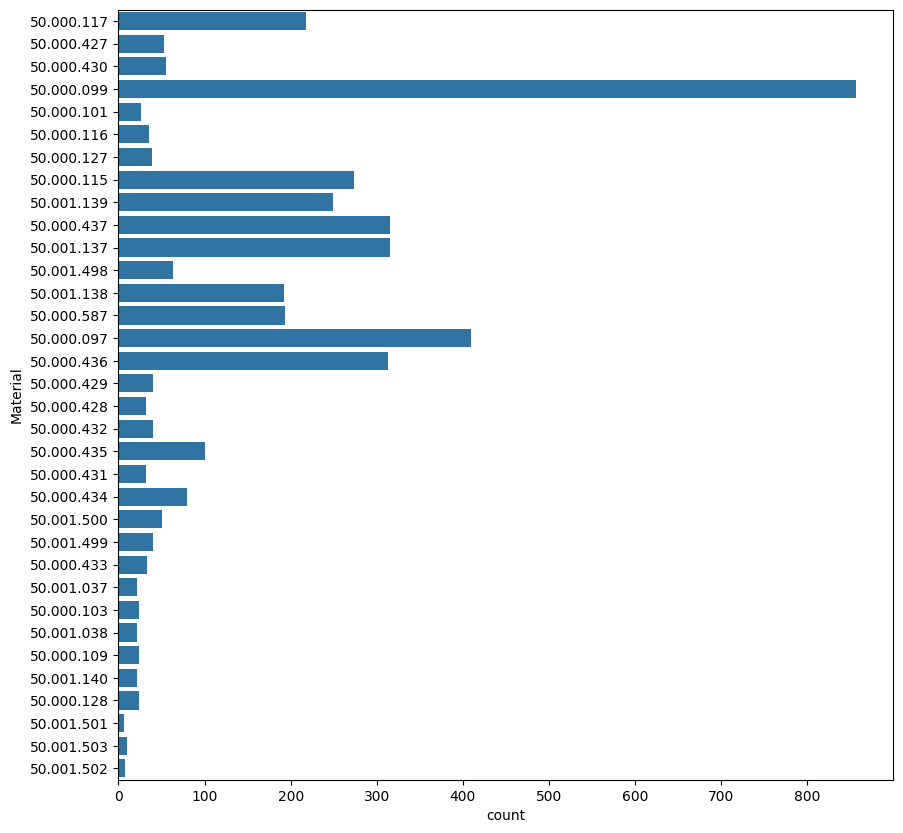

In [5]:
#variável target desbalanciada
print(ds_enquadramento.groupby('Material').size())
plt.subplots(figsize=(10,10))
#ds_enquadramento.value_counts('Material').plot.pie(autopct='%0.2g')
sns.countplot(ds_enquadramento['Material'])


<Axes: xlabel='Reg. Trab.', ylabel='count'>

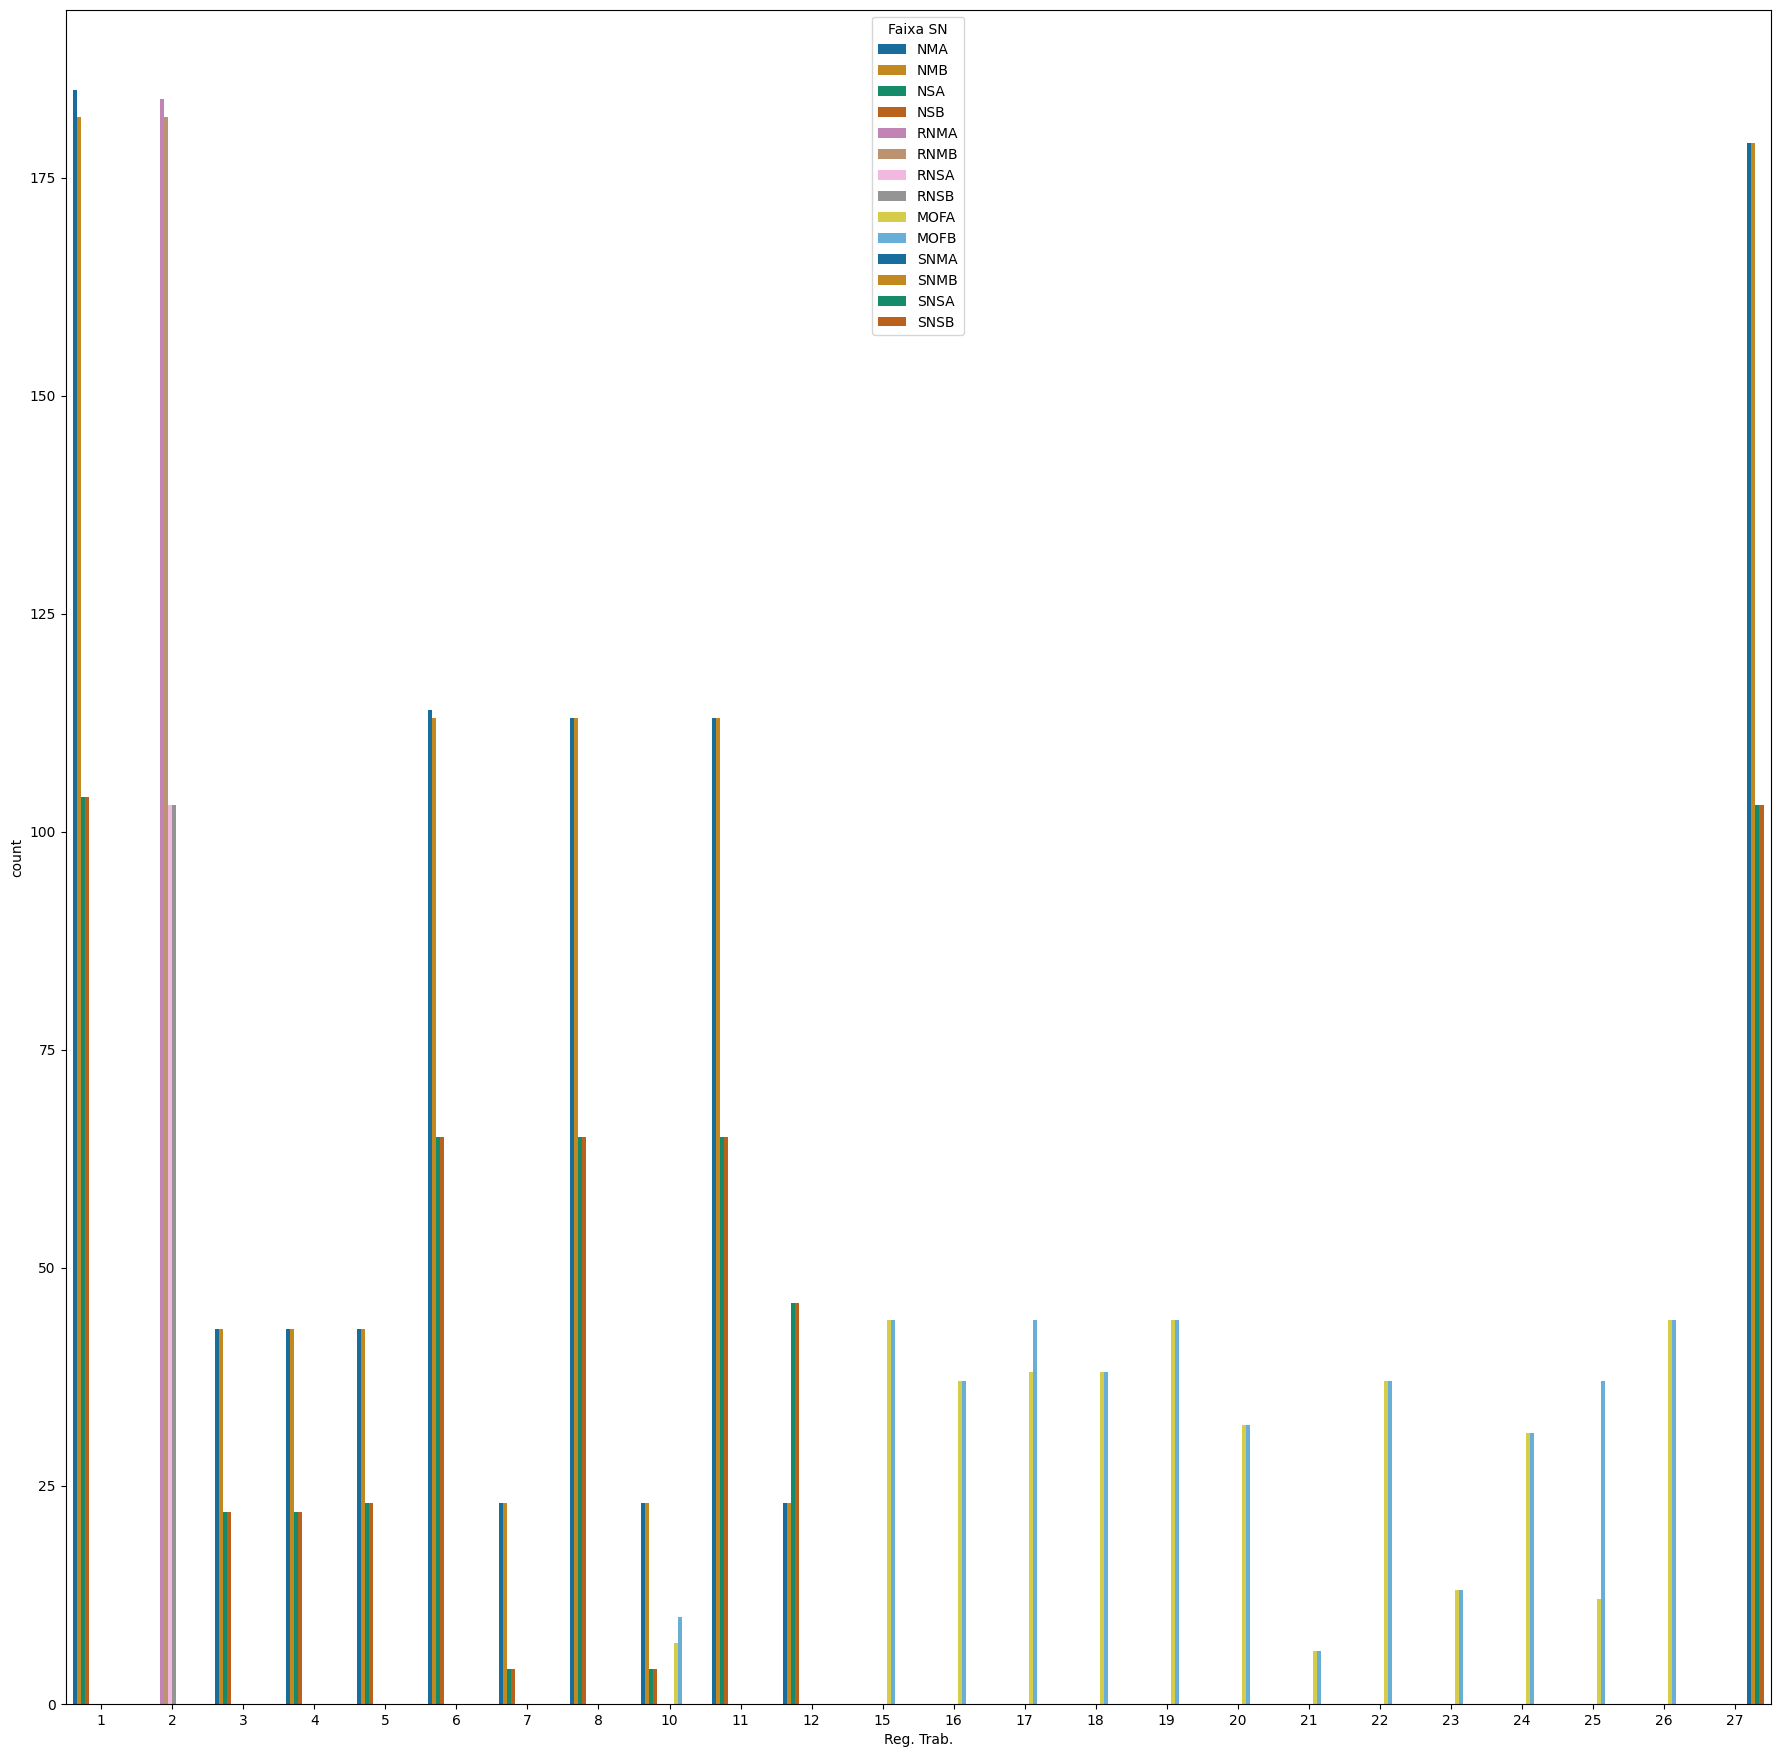

In [7]:
plt.subplots(figsize=(22,22))
sns.countplot(x='Reg. Trab.', hue='Faixa SN', data=ds_enquadramento, palette='colorblind')

In [8]:
#Imprimindo os tipos de dados e valores categóricos
for coluna in ds_enquadramento.columns:
  if ds_enquadramento[coluna].dtype == 'object':
    print(str(coluna) + ' : ' + str(ds_enquadramento[coluna].unique()))
    print(ds_enquadramento[coluna].value_counts())

Faixa SN : ['NSA' 'MOFA' 'MOFB' 'NMA' 'NMB' 'NSB' 'RNMA' 'RNMB' 'RNSA' 'RNSB' 'SNMA'
 'SNMB' 'SNSA' 'SNSB']
NMA     723
NMB     719
NSA     420
NSB     420
MOFB    417
MOFA    383
RNMA    184
RNMB    182
SNMA    179
SNMB    179
RNSA    103
RNSB    103
SNSA    103
SNSB    103
Name: Faixa SN, dtype: int64
TpGR : ['9RC' 'SEM' '9CCE' '9CCN' '9CCT' '9CT' '9GCE' '9RB' '9RG' '9RM' '9CCS'
 '9GCM' '9GS' '9FC']
SEM     642
9RC     593
9RM     593
9RB     592
9RG     577
9GS     237
9CCE    166
9CCN    166
9CCT    166
9CT     166
9GCE    118
9CCS     96
9GCM     96
9FC      10
Name: TpGR, dtype: int64
Material : ['50.000.117' '50.000.427' '50.000.430' '50.000.099' '50.000.101'
 '50.000.116' '50.000.127' '50.000.115' '50.001.139' '50.000.437'
 '50.001.137' '50.001.498' '50.001.138' '50.000.587' '50.000.097'
 '50.000.436' '50.000.429' '50.000.428' '50.000.432' '50.000.435'
 '50.000.431' '50.000.434' '50.001.500' '50.001.499' '50.000.433'
 '50.001.037' '50.000.103' '50.001.038' '50.000.109' '50.001.

In [9]:
#Imprimindo a distribuição dos dados categóricos
ds_enquadramento.select_dtypes(include='object').describe()

,Faixa SN,TpGR,Material
count,4218,4218,4218
unique,14,14,34
top,NMA,SEM,50.000.099
freq,723,642,857


**5) SEPARAÇÃO DO DATASET EM ATRIBUTOS PREVISORES E TARGET E TRANSFORMANDO DADOS CATEGÓRICOS**

In [11]:
ds_enquadramento_previsor = ds_enquadramento.iloc[:, 0:6]
ds_enquadramento_target = ds_enquadramento.iloc[:,6]

#Transformação do target categorico em numérico
ds_enquadramento_target = LabelEncoder().fit_transform(ds_enquadramento_target)


#  FIZ A MODELAGEM USANDO O ONETENCODER E OUTRO USANDO APENAS OS LABELENCONDER NOS ATRIBUTOS CATEGORICOS #

#Conversão variáveis categóricas em representações numéricas
#onehotencoder = pd.get_dummies(data=ds_enquadramento_previsor, columns=['Faixa SN','TpGR'])
ds_enquadramento_previsor = ds_enquadramento_previsor.values
ds_enquadramento_previsor[:,0] = LabelEncoder().fit_transform(ds_enquadramento_previsor[:,0])
ds_enquadramento_previsor[:,3] = LabelEncoder().fit_transform(ds_enquadramento_previsor[:,3])
print(ds_enquadramento_previsor)

#Escalonamento de dados do previsor
scaler = StandardScaler()
ds_enquadramento_previsor = scaler.fit_transform(ds_enquadramento_previsor)

print(ds_enquadramento_previsor)
print(ds_enquadramento_target)

[[4 50.0 12 10 9 0]
 [0 19.5 15 13 7 0]
 [0 19.5 17 13 7 0]
 ...
 [13 28.5 27 13 15 0]
 [13 37.5 27 13 10 0]
 [13 37.5 27 13 9 0]]
[[-0.09559183  0.26362855  0.12274727  0.26990832 -0.73085859 -0.81176741]
 [-1.25506368 -2.39068952  0.44960838  1.07033481 -1.34300346 -0.81176741]
 [-1.25506368 -2.39068952  0.66751579  1.07033481 -1.34300346 -0.81176741]
 ...
 [ 2.51321983 -1.60744812  1.75705283  1.07033481  1.105576   -0.81176741]
 [ 2.51321983 -0.82420673  1.75705283  1.07033481 -0.42478616 -0.81176741]
 [ 2.51321983 -0.82420673  1.75705283  1.07033481 -0.73085859 -0.81176741]]
[ 7 10 10 ... 31  8  8]


**6) APLICAÇÃO DO BALANCIAMENTO DOS DADOS**

In [14]:
#criar o balanceador de dados - Oversampling
smote_bal = SMOTE(random_state=100)
ds_enquadramento_previsor, ds_enquadramento_target = smote_bal.fit_resample(ds_enquadramento_previsor, ds_enquadramento_target )

#variável target balanciada
print(pd.DataFrame(ds_enquadramento_target).groupby(0).size())

#OBS: o balanciamento dos dados tornou a criação e avaliação dos modelos mais lentos.
# Por outro lado, melhorou a acurácia dos modelos

print(pd.DataFrame(ds_enquadramento_previsor).value_counts())

0
0     857
1     857
2     857
3     857
4     857
5     857
6     857
7     857
8     857
9     857
10    857
11    857
12    857
13    857
14    857
15    857
16    857
17    857
18    857
19    857
20    857
21    857
22    857
23    857
24    857
25    857
26    857
27    857
28    857
29    857
30    857
31    857
32    857
33    857
dtype: int64
0          1          2          3          4          5        
-1.255064  -2.390690   0.449608   1.070335  -1.343003  -0.811767    1
 0.132767  -1.607448  -0.857836   1.070335   1.105576  -0.811767    1
 0.135433  -2.521230   0.013794   1.070335  -0.424786  -0.811767    1
           -3.391498   0.013794   1.070335   1.105576  -0.811767    1
 0.135289  -0.824207  -0.857836   1.070335  -0.424786  -0.811767    1
                                                                   ..
-0.437833   0.437682   0.013794  -0.263709   0.493431  -0.811767    1
-0.437875   0.263629   0.013794  -1.864562  -0.063368  -0.811767    1
-0.437970   0.046061

<Axes: >

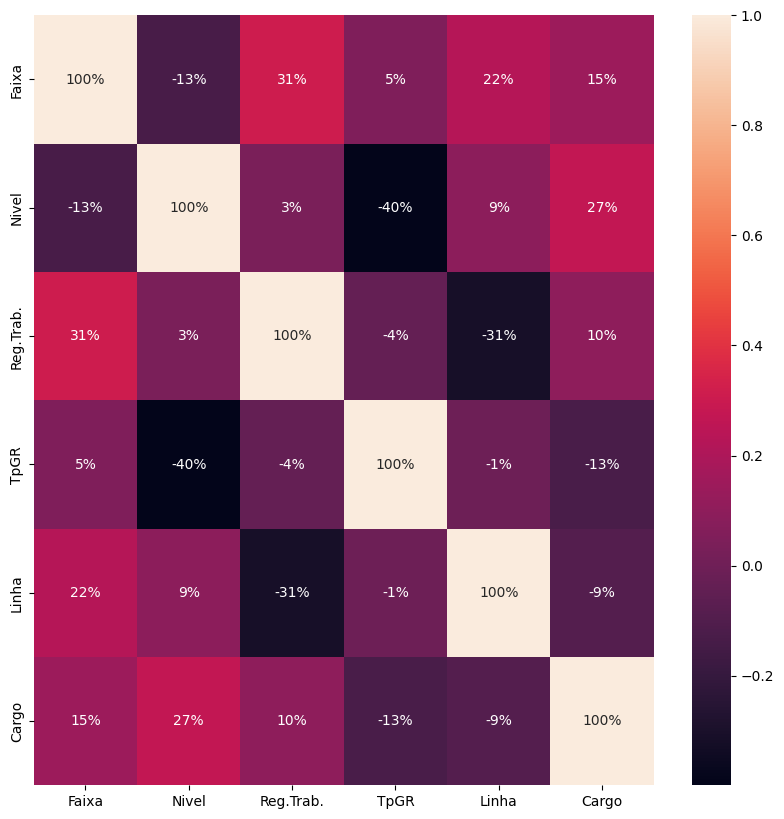

In [24]:
#visualizando as correlações entre os atributos previsores
plt.subplots(figsize=(10,10))
ds_enquadramento_corr = pd.DataFrame(ds_enquadramento_previsor, columns=['Faixa','Nivel','Reg.Trab.','TpGR','Linha','Cargo'])
sns.heatmap(ds_enquadramento_corr.corr(), annot=True, fmt='.0%')

**7) SEPARAÇÃO EM CONJUNTO DE TREINO E CONJUNTO DE TESTE**


In [16]:
# holdout com estratificação
X_enquadramento_train, X_enquadramento_test, y_enquadramento_train, y_enquadramento_test = train_test_split(ds_enquadramento_previsor, ds_enquadramento_target, test_size=0.30, random_state=7, stratify=ds_enquadramento_target)
print ('X Treino Enquadramento')
print (X_enquadramento_train)

print ('Y Treino Enquadramento')
print (y_enquadramento_train)


X Treino Enquadramento
[[-0.09559183 -1.60744812 -0.66743786  1.07033481  1.105576   -0.81176741]
 [-0.38545979  0.26362855 -0.49321259  0.00309949 -0.11871373  1.22782155]
 [-0.0266062   0.26362855 -0.53097495  0.00309949  1.105576   -0.81176741]
 ...
 [-1.25506368  0.74227607  0.82826747  1.07033481 -1.64907589 -0.81176741]
 [ 0.19427613 -0.82420673 -0.72258252  1.07033481 -0.73085859 -0.81176741]
 [-0.41188386 -1.47690789 -0.63992865  1.07033481 -0.11871373 -0.81176741]]
Y Treino Enquadramento
[33 19  7 ...  2 27 12]


**8) CRIAÇÃO E AVALIAÇÃO DOS MODELOS: LINHA DE BASE**

Validação cruzada: 10 partições:

VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.28 (+/- 0.012550) [LR]
VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.92 (+/- 0.006581) [CART]
VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.83 (+/- 0.006715) [KNN]
VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.62 (+/- 0.010795) [NB]
VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: 0.84 (+/- 0.012724) [VOTING]


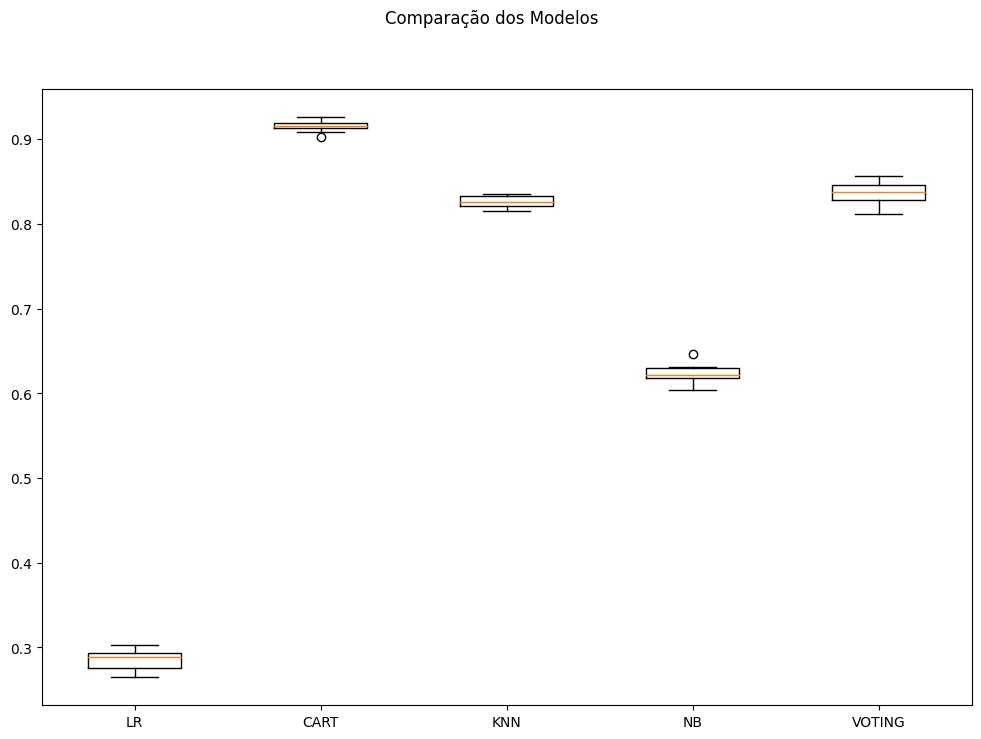

In [17]:
# CRIAÇÃO DAS INSTÂNCIAS DOS MODELOS

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # 4218 registros / 10 ~= 422 registros em cada subconjunto

np.random.seed(7) # definindo uma semente global

class_regr_logistica = LogisticRegression(penalty='l2', solver='liblinear', C=0.001, random_state = 1)
#class_arv_decicao = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state = 1) #gerando uma acurácia ruim
class_arv_decicao = DecisionTreeClassifier()
class_knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
class_naive_bayes = GaussianNB()

clf_labels = [ 'LR', 'CART', 'KNN', 'NB','VOTING']
resultados = []
nomes = []

print('Validação cruzada: 10 partições:\n')

#criando os modelos para VotingClassifier
class_voting = ensemble.VotingClassifier(estimators=[('lr', class_regr_logistica), ('cart', class_arv_decicao), ('knn', class_knn), ('nb', class_naive_bayes)], voting='hard')
all_clf = [class_regr_logistica, class_arv_decicao, class_knn, class_naive_bayes, class_voting]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_enquadramento_train, y=y_enquadramento_train, cv=kfold, scoring=scoring)
    resultados.append(scores)
    nomes.append(clf)
    print("VALIDAÇÃO CRUZADA - ACURÁCIA accuracy: %0.2f (+/- %f) [%s]" % (scores.mean(), scores.std(), label))

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(12,8))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(clf_labels)
plt.show()

**9) CRIAÇÃO E AVALIAÇÃO DOS MODELOS: DADOS PADRONIZADOS E NORMALIZADOS**



LR-orig: 0.48 (0.01)
CART-orig: 0.92 (0.01)
KNN-orig: 0.83 (0.01)
NB-orig: 0.62 (0.01)
Vot-orig: 0.84 (0.01)
LR-padr: 0.48 (0.01)
CART-padr: 0.92 (0.01)
KNN-padr: 0.83 (0.01)
NB-padr: 0.62 (0.01)
Vot-padr: 0.83 (0.01)
LR-norm: 0.46 (0.01)
CART-norm: 0.92 (0.01)
KNN-norm: 0.84 (0.01)
NB-norm: 0.62 (0.01)
Vot-norm: 0.84 (0.02)


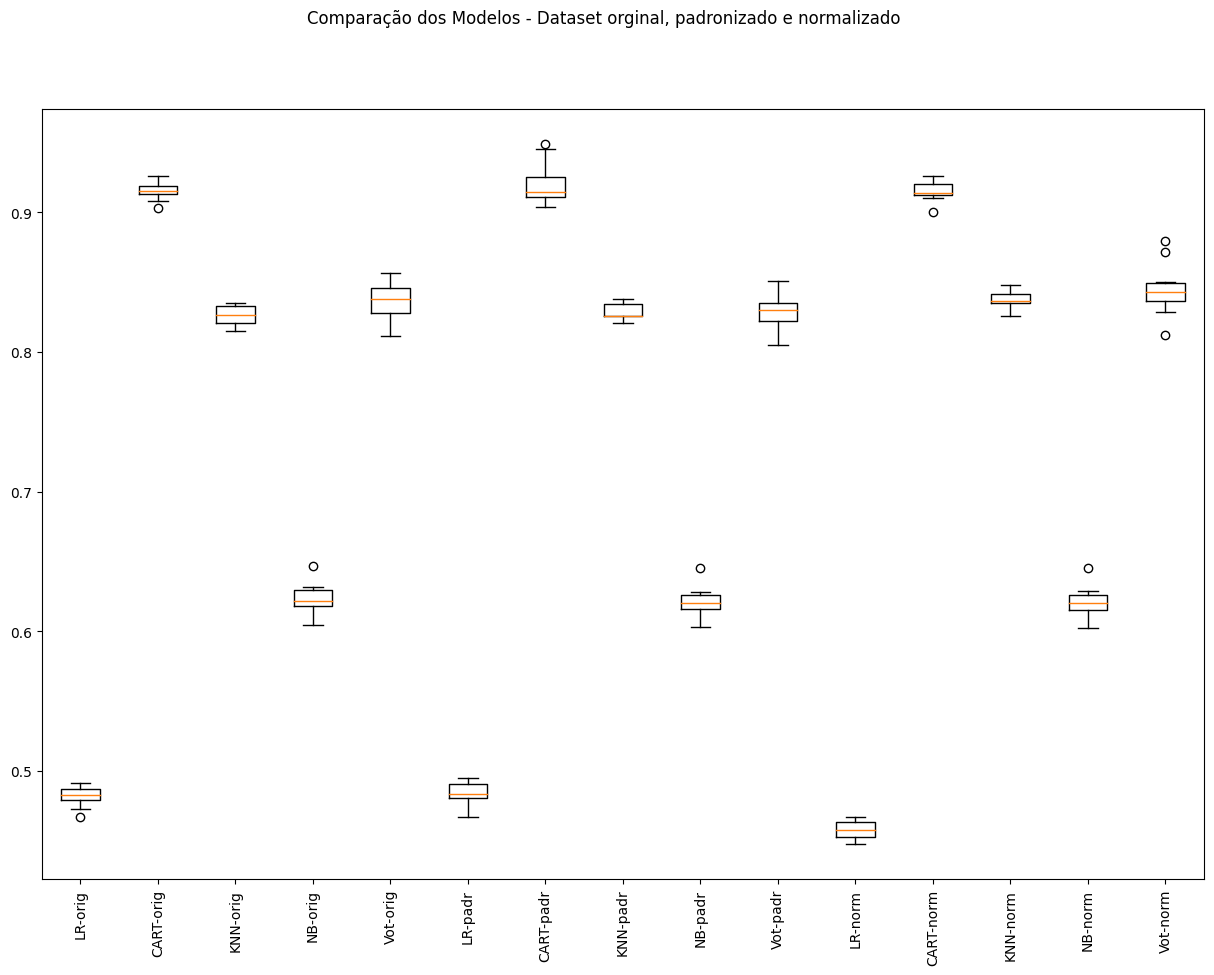

In [32]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Algoritmos que serão utilizados

#class_regr_logistica = LogisticRegression(penalty='l2', solver='liblinear', C=0.001, random_state = 1)

reg_log = ('LR',  LogisticRegression(max_iter=200))
cart = ('CART', DecisionTreeClassifier())
knn = ('KNN', KNeighborsClassifier())
naive_bayes = ('NB', GaussianNB())
voting = ('Voting', class_voting)

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_enquadramento_train, y_enquadramento_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.2f (%.2f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

**10) OTIMIZAÇÃO DE HIPERPARÂMETROS**

In [33]:
# Tuning do KNN usando GridSearch e RandonSearch

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_enquadramento_train, y_enquadramento_train)
    # imprime a melhor configuração
    treinos_knn = pd.DataFrame(grid.cv_results_)
    print("GridSearchCV: %s - Melhor: %0.2f usando %s, Número treinamento: %s " % (name, grid.best_score_, grid.best_params_, treinos_knn.shape[0]))


# Prepara e executa o RandonSearch
for name, model in pipelines:
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, cv=kfold, n_jobs = 8, n_iter = 10)
    grid.fit(X_enquadramento_train, y_enquadramento_train)
    # imprime a melhor configuração
    treinos_knn = pd.DataFrame(grid.cv_results_)
    print("RandonSearchCV: %s - Melhor: %0.2f usando %s, Número treinamento: %s " % (name, grid.best_score_, grid.best_params_, treinos_knn.shape[0]))

GridSearchCV: knn-orig - Melhor: 0.85 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}, Número treinamento: 33 
GridSearchCV: knn-padr - Melhor: 0.85 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}, Número treinamento: 33 
GridSearchCV: knn-norm - Melhor: 0.86 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1}, Número treinamento: 33 
RandonSearchCV: knn-orig - Melhor: 0.84 usando {'KNN__n_neighbors': 5, 'KNN__metric': 'manhattan'}, Número treinamento: 10 
RandonSearchCV: knn-padr - Melhor: 0.84 usando {'KNN__n_neighbors': 9, 'KNN__metric': 'manhattan'}, Número treinamento: 10 
RandonSearchCV: knn-norm - Melhor: 0.86 usando {'KNN__n_neighbors': 7, 'KNN__metric': 'manhattan'}, Número treinamento: 10 


**11) AVALIAÇÃO DO MODELO COM O CONJUNTO DE TESTE**

In [34]:
# Avaliação do modelo com o conjunto de testes

print('Avaliando Conjunto de testes:\n')

for clf, label in zip([class_regr_logistica, class_arv_decicao, class_knn, class_naive_bayes], clf_labels):
    clf.fit(X=X_enquadramento_train, y=y_enquadramento_train) # Criando um modelo com todo o conjunto de treino
    predictions = clf.predict(X_enquadramento_test) # Fazendo as predições com o conjunto de teste
    print("AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: %0.2f " % (accuracy_score(y_enquadramento_test, predictions)), label) # Estimando a acurácia no conjunto de teste
    #print(confusion_matrix(y_enquadramento_test,predictions))

Avaliando Conjunto de testes:

AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: 0.30  LR
AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: 0.92  CART
AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: 0.83  KNN
AVALIAÇÃO DO MODELO - ACURÁCIA accuracy: 0.63  NB


**12) SIMULAÇÃO DA APLICAÇÃO COM DADOS NÃO VISTOS - NÃO SABEMOS A CLASSE**

In [38]:
# Preparação do modelo com TODO o dataset
class_naive_bayes_model = GaussianNB()
class_naive_bayes_model.fit(ds_enquadramento_previsor, ds_enquadramento_target)

class_regr_logistica_model = LogisticRegression(penalty='l2', solver='liblinear', C=0.001, random_state = 1)
class_regr_logistica_model.fit(ds_enquadramento_previsor, ds_enquadramento_target)

#usando os hiperparâmetros com melhor acurácia
class_knn_model = KNeighborsClassifier(n_neighbors=5, p=2, metric='manhattan')
class_knn_model.fit(ds_enquadramento_previsor, ds_enquadramento_target)

class_arv_decicao_model = DecisionTreeClassifier()
class_arv_decicao_model.fit(ds_enquadramento_previsor, ds_enquadramento_target)

# Novos dados - não sabemos a classe!
novos_dados = {'Faixa':  ['NMB','NSB','SNMB','NSA'],
        'Nivel': [88, 23, 67, 19],
        'Reg': [6, 1, 27, 1],
        'TpGr': ['9RG', 'SEM','9RB', 'SEM'],
        'Cargo': [51174657, 0, 51174657, 0],
        'Linha': [12, 9, 14, 9],
        }

atributos = ['Faixa', 'Nivel', 'Reg', 'TpGr', 'Linha', 'Cargo']
ds_entrada = pd.DataFrame(novos_dados, columns=atributos)
array_entrada = ds_entrada.values

#transformando dados categoricos
array_entrada[:,0] = LabelEncoder().fit_transform(array_entrada[:,0])
array_entrada[:,3] = LabelEncoder().fit_transform(array_entrada[:,3])

#Escalonamento de dados
scaler = StandardScaler()
array_entrada = scaler.fit_transform(array_entrada)
#print(array_entrada)

#previsão do modelo com novos dados
previsao_nb = class_naive_bayes_model.predict(array_entrada)
previsao_lr = class_regr_logistica_model.predict(array_entrada)
previsao_knn = class_knn_model.predict(array_entrada)
previsao_cart = class_arv_decicao_model.predict(array_entrada)

enconder = LabelEncoder()
enconder.fit(ds_enquadramento['Material'])

lista_decodificada_nb = enconder.inverse_transform(previsao_nb)
print('PREVISÃO Naive Bayer')
print(previsao_nb)
print(lista_decodificada_nb)
print('\n')

lista_decodificada_lr = enconder.inverse_transform(previsao_lr)
print('PREVISÃO Regressão Logística')
print(previsao_lr)
print(lista_decodificada_lr)
print('\n')

lista_decodificada_knn = enconder.inverse_transform(previsao_knn)
print('PREVISÃO KNN')
print(previsao_knn)
print(lista_decodificada_knn)
print('\n')

lista_decodificada_cart = enconder.inverse_transform(previsao_cart)
print('PREVISÃO CART')
print(previsao_cart)
print(lista_decodificada_cart)
print('\n')



PREVISÃO Naive Bayer
[20  1 20  1]
['50.000.437' '50.000.099' '50.000.437' '50.000.099']


PREVISÃO Regressão Logística
[19  2 25  6]
['50.000.436' '50.000.101' '50.001.138' '50.000.116']


PREVISÃO KNN
[19 27 25 27]
['50.000.436' '50.001.140' '50.001.138' '50.001.140']


PREVISÃO CART
[25  8 25  8]
['50.001.138' '50.000.127' '50.001.138' '50.000.127']




**13) CONCLUSÃO: O MODELO NÃO PREVE VALORES DE MATERIAL COM ACURÁCIA, PODENDO GERAR PROBLEMAS NO FATURAMENTO AOS CLIENTES.**